In [ ]:
# import the libraries

In [ ]:
conda install py-xgboost

In [248]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
import xgboost as xgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
import time
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import roc_curve, auc
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image  
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree 
import itertools

In [425]:
df = pd.read_csv('final_dataframe.csv',index_col=0)

In [426]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1646 entries, 0 to 1670
Data columns (total 16 columns):
ISBN               1646 non-null int64
title              1646 non-null object
series             1646 non-null int64
author             1646 non-null object
rating             1646 non-null float64
genre              1646 non-null object
publish_date       1645 non-null object
publish_company    1637 non-null object
format             1645 non-null object
number_of_pages    1646 non-null int64
publish_month      1646 non-null object
publish_year       1646 non-null int64
NYT_bestseller     1646 non-null float64
length_of_title    1646 non-null int64
top_authors        1646 non-null int64
top5               1646 non-null int64
dtypes: float64(2), int64(7), object(7)
memory usage: 218.6+ KB


# Set up for modeling

In [441]:
feats = ['series','rating','publish_month',
         'publish_company','genre','top_authors']

X = pd.get_dummies(df[feats], drop_first=True)

In [442]:
# for publisher, genre, and month of publishing, i only want the "important ones"
# which i have deemed to be anything where the count was over 10 

X.drop([col for col, val in X.sum().iteritems() if val < 10], axis=1, inplace=True)

In [444]:
len(X.columns)

42

In [445]:
# Y is the target variable
Y = df['NYT_bestseller']

In [446]:
X.head()

,series,rating,top_authors,publish_month_August,publish_month_December,publish_month_February,publish_month_January,publish_month_July,publish_month_June,publish_month_March,...,genre_non-fiction,genre_poetry,genre_politics,genre_romance,genre_science-fiction,genre_sequential-art,genre_short-stories,genre_sports-and-games,genre_thriller,genre_young-adult
0,0,4.17,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,4.11,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,4.09,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,4.16,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,4.08,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [447]:
# normalize the features

for col in X.columns:
    X[col] = (X[col]-min(X[col]))/ (max(X[col]) - min(X[col])) 

#We subtract the minimum and divide by the range forcing a scale of 0 to 1 for each feature

X.head()

,series,rating,top_authors,publish_month_August,publish_month_December,publish_month_February,publish_month_January,publish_month_July,publish_month_June,publish_month_March,...,genre_non-fiction,genre_poetry,genre_politics,genre_romance,genre_science-fiction,genre_sequential-art,genre_short-stories,genre_sports-and-games,genre_thriller,genre_young-adult
0,0.0,0.624434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.597285,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.588235,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.619910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.583710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [448]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

# Baseline: 

In [434]:
df['NYT_bestseller'].value_counts(normalize=True)

0.0    0.665249
1.0    0.334751
Name: NYT_bestseller, dtype: float64

In [435]:
dum_clf = DummyClassifier(strategy='most_frequent')
dum_model = dum_clf.fit(X_train,y_train)
y_hat_train = dum_clf.predict(X_train)
y_hat_test = dum_model.predict(X_test)

In [439]:
print(accuracy_score(y_hat_train,y_train))
print(accuracy_score(y_hat_test,y_test))

0.6595744680851063
0.6878787878787879


Confusion matrix, without normalization
[[227   0]
 [103   0]]


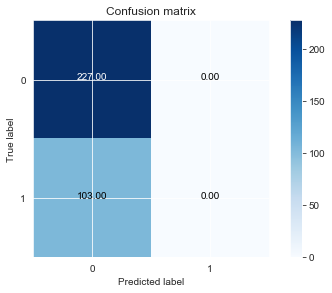

In [438]:
cnf_matrix = confusion_matrix(y_test, y_hat_test)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],normalize=False,
                      title='Confusion matrix')
plt.show()

In [261]:
# i need my model to perform better than 66%!

In [262]:
# for this specific classification problem, I have focused on increasing accuracy and F1 given that 
# i believe a false positive and false negative are equally "bad" and 
# FP = not really a best seller, but my model said it was (wasted investment)
# FN = a best seller but my model said it wasn't (missed business opportunity)
# my goal should be to make the most accurate model possible

## Helper Functions

In [16]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

In [398]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion')

In [18]:
def plot_AUC_ROC(y_score,fpr,tpr):
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10,8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [49]:
def plot_feature_importance(model, x_train, n=30):
    # extract and sort the feature importance
    features = model.feature_importances_
    columns = x_train.columns.values
    
    # combine the features importance and column names into a matrix and sort them
    feature_matrix = np.array([features, columns])
    feature_matrix = feature_matrix.transpose()
    feature_matrix.sort(0)
    
    # divide the column names and feature importance
    sorted_feat = feature_matrix[:, 0]
    sorted_columns = feature_matrix[:, 1]
    
     # plot the features
    plt.figure(figsize=(16, 12))
    try:
        plt.barh(sorted_columns[-n:], sorted_feat[-n:], align='center')
    
    except:
        # if n features is greater than the amount that actually exists
        n = len(sorted_feat)
        plt.barh(sorted_columns[-n:], sorted_feat[-n:], align='center')
        
    plt.yticks(sorted_columns[-n:], sorted_columns[-n:])
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    return

# Model 1: Logistic Regression

In [330]:
logreg = LogisticRegression(fit_intercept = False, solver='liblinear')
model_log = logreg.fit(X_train, y_train)
model_log

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [331]:
# Inverse regularization parameter - A control variable that retains strength 
# modification of Regularization by being inversely positioned to the Lambda regulator.

# high C = overfit, low C= underfit
# want a C value that minimizes the difference b/w train and test accuracy

# C = 1/λ

In [332]:
# y_hat predicted values
y_hat_test_log = logreg.predict(X_test)
y_hat_train_log = logreg.predict(X_train)

### Evaluate

In [333]:
# metrics
print_metrics(y_hat_train_log, y_train)
print('----------')
print_metrics(y_hat_test_log,y_test)

Precision Score: 0.43507972665148065
Recall Score: 0.6945454545454546
Accuracy Score: 0.7477203647416414
F1 Score: 0.5350140056022409
----------
Precision Score: 0.41964285714285715
Recall Score: 0.6266666666666667
Accuracy Score: 0.7181818181818181
F1 Score: 0.5026737967914437


In [ ]:
# accuracy: things the model classified correctly - this means we are about 6% better than baseline!

In [383]:
# confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat_test_log)
print(cnf_matrix)
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True,classes=[0,1],
                      title='Normalized confusion matrix')
plt.show()


[[190  28]
 [ 65  47]]


Normalized confusion matrix
[[0.87155963 0.12844037]
 [0.58035714 0.41964286]]


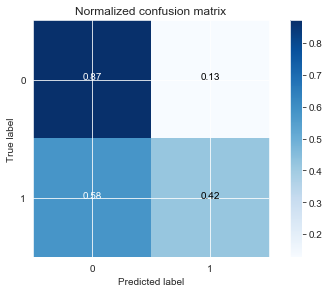

In [399]:
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True,classes=[0,1],
                      title='Normalized confusion matrix')
plt.show()


In [336]:
# TP = 47
# TN = 196
# FP = 21
# FN = 66

In [337]:
# ROC/AUC
#First calculate the probability scores of each of the datapoints:
y_test_score = model_log.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_test_score)

y_train_score = model_log.decision_function(X_train)

train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

AUC: 0.7263679554390563


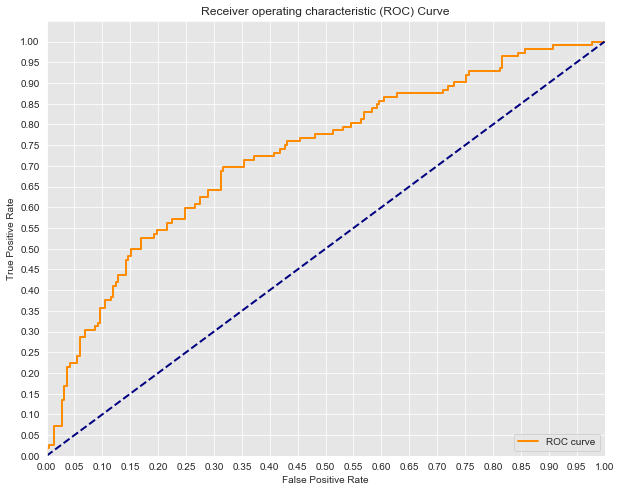

In [338]:
plot_AUC_ROC(y_test_score,fpr,tpr)

In [339]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

clf_2 = GridSearchCV(LogisticRegression(solver='liblinear'), hyperparameters, cv=5, verbose=0)

In [340]:
best_model = clf_2.fit(X_train, y_train)

In [341]:
# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l1
Best C: 59.94842503189409


In [342]:
# Grid Search
logreg_2 = LogisticRegression(fit_intercept = False, solver='liblinear', C=59.9, penalty='l1')
model_log = logreg_2.fit(X_train, y_train)
model_log

LogisticRegression(C=59.9, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [343]:
y_hat_test_2 = best_model.predict(X_test)

In [345]:
print_metrics(y_hat_test_2,y_test)

Precision Score: 0.44642857142857145
Recall Score: 0.6172839506172839
Accuracy Score: 0.7181818181818181
F1 Score: 0.5181347150259068


In [379]:
model_log.coef_

array([[ 0.60797552,  0.22067547,  1.35505663,  1.53617295,  0.33840161,
         0.26626985,  1.40801222, -0.45985178, -0.59595705, -0.44142811,
        -0.29442353, -0.0639494 , -0.85293531,  0.57115942,  0.09472215,
         0.17198224,  0.45874246,  0.23561703,  0.48830429, -0.27002226,
         0.46112719, -0.37162881, -0.82492094, -0.08098427, -0.26374125,
        -7.10842637, -2.57338057, -2.04358852,  5.72058048, -2.02638743,
        -0.48177447, -3.4906098 , -1.64640544, -1.3586599 , -0.88293957,
        -0.57276674,  2.15384367, -2.07630251, -2.9056989 , -0.99894751,
        -2.75752184,  1.02567467, -1.51332766, -1.88479623]])

[[187  31]
 [ 62  50]]
Normalized confusion matrix
[[0.85779817 0.14220183]
 [0.55357143 0.44642857]]


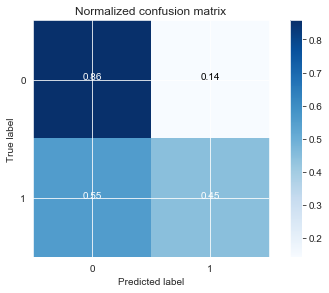

In [423]:
cnf_matrix = confusion_matrix(y_test, y_hat_test_2)
print(cnf_matrix)
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True,classes=[0,1],
                      title='Normalized confusion matrix')
plt.show()


# Model 2: KNN

In [449]:
model_KNN = KNeighborsClassifier()
model_KNN.fit(X_train, y_train)
y_hat_test_KNN = model_KNN.predict(X_test)
y_hat_train_KNN = model_KNN.predict(X_train)

In [450]:
print_metrics(y_train,y_hat_train_KNN)
print("---------")
print_metrics(y_test, y_hat_test_KNN)

Precision Score: 0.7477744807121661
Recall Score: 0.5714285714285714
Accuracy Score: 0.7917933130699089
F1 Score: 0.6478149100257069
---------
Precision Score: 0.573170731707317
Recall Score: 0.42727272727272725
Accuracy Score: 0.703030303030303
F1 Score: 0.48958333333333326


In [348]:
# accuracy score went up for train set, but down for test set - let's try to tune our hyperparameters

In [451]:
params = {'n_neighbors': [1,3,5,7,9,11,13,15],
          'weights':['uniform','distance'],
          'metric':['euclidean','manhattan']}
gs=GridSearchCV(KNeighborsClassifier(),params,n_jobs=-1, verbose=1, cv=3)
gs_results = gs.fit(X_train,y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    7.1s finished


In [452]:
print(gs_results.best_params_)
print(gs_results.best_score_)

{'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'uniform'}
0.6945288753799392


In [453]:
model_KNN = KNeighborsClassifier(metric='euclidean', n_neighbors=15,weights='uniform')
model_KNN.fit(X_train, y_train)
y_hat_test_KNN2 = model_KNN.predict(X_test)
y_hat_train_KNN2 = model_KNN.predict(X_train)

In [454]:
print_metrics(y_hat_test_KNN2,y_test)

Precision Score: 0.38181818181818183
Recall Score: 0.65625
Accuracy Score: 0.7272727272727273
F1 Score: 0.48275862068965525


[[188  30]
 [ 74  38]]


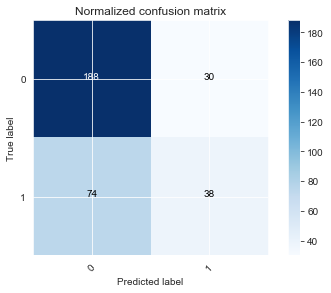

In [353]:
cnf_matrix = confusion_matrix(y_test, y_hat_test_KNN2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Normalized confusion matrix')
plt.show()

# # KNN seems to perform worse than log reg, despite using grid search to optimize parameters 
# so let's move on

In [354]:
# - weights which can be set to either ‘uniform’, where each neighbor 
# within the boundary carries the same weight or ‘distance’ where closer 
# points will be more heavily weighted toward the decision. 
# Note that when weights = 'distance' the class with the highest number in the boundary may not “win the vote”

## Model 3: Decision Tree

In [455]:
DT_clf= DecisionTreeClassifier()
DT_clf.fit(X_train,y_train) 
y_hat_test_DT = DT_clf.predict(X_test)

In [456]:
print_metrics(y_test,y_hat_test_DT) # pretty low accuracy score with default params, let's try Random search!
# random search will try a bunch of random values within the range we gave for each parameter
# after that, we can use grid search around the values random search says to use!

Precision Score: 0.5
Recall Score: 0.5454545454545454
Accuracy Score: 0.6666666666666666
F1 Score: 0.5217391304347826


In [457]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distrib = {"max_depth": randint(1, 50),
                 "max_features": randint(1, 16),
                 "min_samples_leaf": randint(2, 1000),
                 "min_samples_split": randint(2, 1000),
                }
DT_clf = RandomizedSearchCV(DecisionTreeClassifier(), param_distrib, n_iter=500, cv=3)

In [458]:
DT_clf.fit(X_train,y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          fit_params=None, iid='warn', n_iter=500, n_jobs=None,
          param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a25d4a358>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a25d4ac50>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a25d5bac8>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a25d5b208>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=

In [459]:
DT_clf.best_params_

{'max_depth': 48,
 'max_features': 11,
 'min_samples_leaf': 3,
 'min_samples_split': 622}

In [460]:
DT_clf2 = DT_clf.best_estimator_

In [461]:
DT_clf2.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=48,
            max_features=11, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=622,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [462]:
y_hat_test_DT2 = DT_clf2.predict(X_test)

In [463]:
print_metrics(y_hat_test_DT2,y_test) #this is a little better!

Precision Score: 0.11818181818181818
Recall Score: 0.8125
Accuracy Score: 0.696969696969697
F1 Score: 0.20634920634920637


In [464]:
# grid search based on random search params
params = {"max_depth": [30, 40,50],
                 "max_features": [10,14,20],
                 "min_samples_leaf": [160,170,180,190,200],
                 "min_samples_split": [240,250,260,270,280],
                }
gs=GridSearchCV(DecisionTreeClassifier(),params,n_jobs=-1, verbose=1, cv=3)
gs_results = gs.fit(X_train,y_train)

Fitting 3 folds for each of 225 candidates, totalling 675 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 668 out of 675 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed:    2.1s finished


In [465]:
gs_results.best_params_

{'max_depth': 30,
 'max_features': 10,
 'min_samples_leaf': 160,
 'min_samples_split': 240}

In [467]:
DT_clf3 = DecisionTreeClassifier(max_depth=30,max_features=10,min_samples_leaf=160,min_samples_split=240)

In [468]:
DT_clf3.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=30,
            max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=160, min_samples_split=240,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [469]:
y_hat_DT = DT_clf3.predict(X_test)

In [470]:
print_metrics(y_hat_DT,y_test)

Precision Score: 0.0
Recall Score: 0.0
Accuracy Score: 0.6666666666666666
F1 Score: 0.0


/Users/Kristinabarounis/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/Kristinabarounis/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [ ]:
# this model can't do better than the dummy classifier - so decision trees are a no go!

## Model 4: Random Forest

In [471]:
forest_clf = RandomForestClassifier(n_estimators=100)
forest_clf.fit(X_train, y_train)
y_hat_test = forest_clf.predict(X_test)

In [472]:
forest_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [473]:
accuracy_score(y_hat_test,y_test)

0.7121212121212122

In [474]:
# pretty good accuracy score, let's try random search

In [475]:
param_distrib = {"n_estimators": randint(1,100),
                "max_depth": randint(1, 50),
                 "max_features": randint(1, 16),
                 "min_samples_leaf": randint(2, 1000),
                 "min_samples_split": randint(2, 1000),
                }
Forest_clf = RandomizedSearchCV(RandomForestClassifier(), param_distrib, n_iter=500, cv=3)

In [476]:
Forest_clf.fit(X_train,y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=500, n_jobs=None,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a256de4a8>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a256debe0>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a256de668>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a256dee80>, 'min_samples_split': <scipy.stats._distn_infrastructu

In [477]:
Forest_clf.best_params_

{'max_depth': 32,
 'max_features': 12,
 'min_samples_leaf': 10,
 'min_samples_split': 56,
 'n_estimators': 42}

In [478]:
y_hat_forest = Forest_clf.predict(X_test)
accuracy_score(y_hat_forest,y_test)

0.6909090909090909

In [409]:
# accuracy score went down from baseline, let's try grid search with these params/ranges

In [479]:
params = {"n_estimators": [40,45,50],
                "max_depth": [20,21,22],
                 "max_features": [12,14,16],
                 "min_samples_leaf": [5,6,7],
                 "min_samples_split": [350,360,370],
                }

forest_grid_search = GridSearchCV(RandomForestClassifier(), params, cv=3)
forest_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [40, 45, 50], 'max_depth': [20, 21, 22], 'max_features': [12, 14, 16], 'min_samples_leaf': [5, 6, 7], 'min_samples_split': [350, 360, 370]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [480]:
forest_grid_search.best_params_

{'max_depth': 21,
 'max_features': 14,
 'min_samples_leaf': 5,
 'min_samples_split': 350,
 'n_estimators': 40}

In [412]:
forest_clf_2 = forest_grid_search.best_estimator_

In [413]:
forest_clf_2.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=21, max_features=12, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=350,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [414]:
y_hat_forest2 = forest_clf_2.predict(X_test)

In [415]:
accuracy_score(y_hat_forest2,y_test)

0.6727272727272727

In [ ]:
# go back to try baseline and fine tuning those parameters 

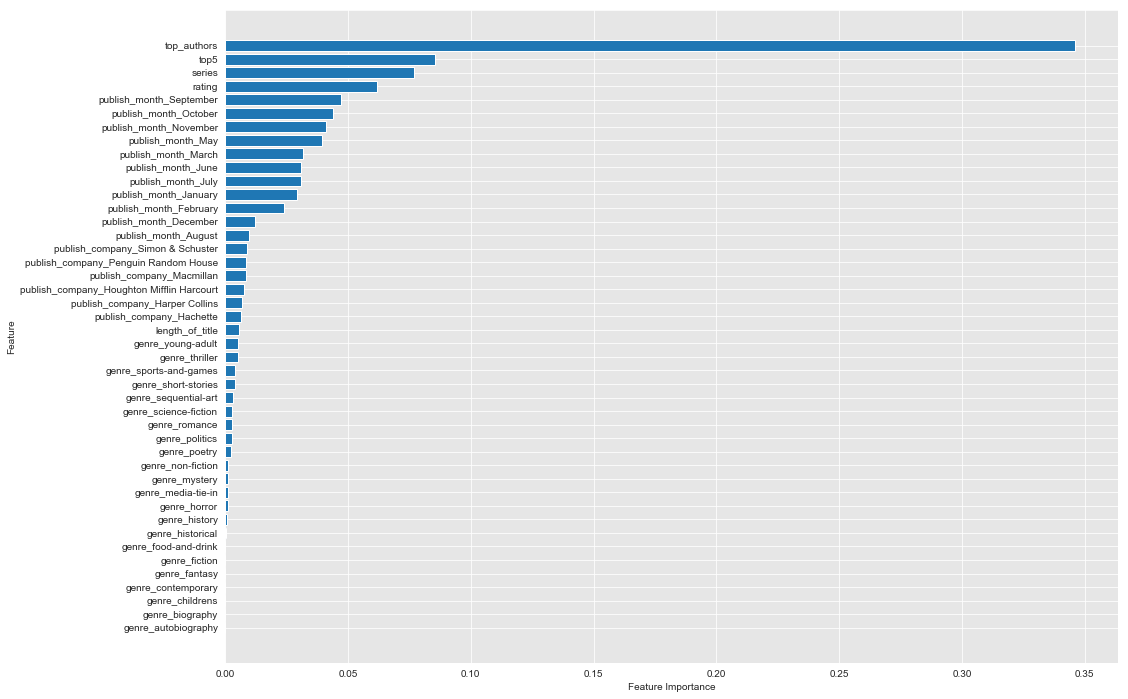

In [416]:
plot_feature_importance(forest_clf_2,X_train,n=44)

## Model 5: XGBoost

In [417]:
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)
y_hat_train = clf.predict(X_train)
y_hat_test = clf.predict(X_test)
training_accuracy = accuracy_score(y_train, y_hat_train)
val_accuracy = accuracy_score(y_test, y_hat_test)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Training Accuracy: 76.44%
Validation accuracy: 69.7%


In [420]:
param_grid = {
    "learning_rate": [0.5, 0.1],
    'max_depth': [4,5,6],
    'min_child_weight': [10],
    'subsample': [ 0.7],
    'n_estimators': [5, 30, 100, 250],
}

In [421]:
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=3, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
val_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 10
n_estimators: 30
subsample: 0.7

Training Accuracy: 72.49%
Validation accuracy: 65.45%


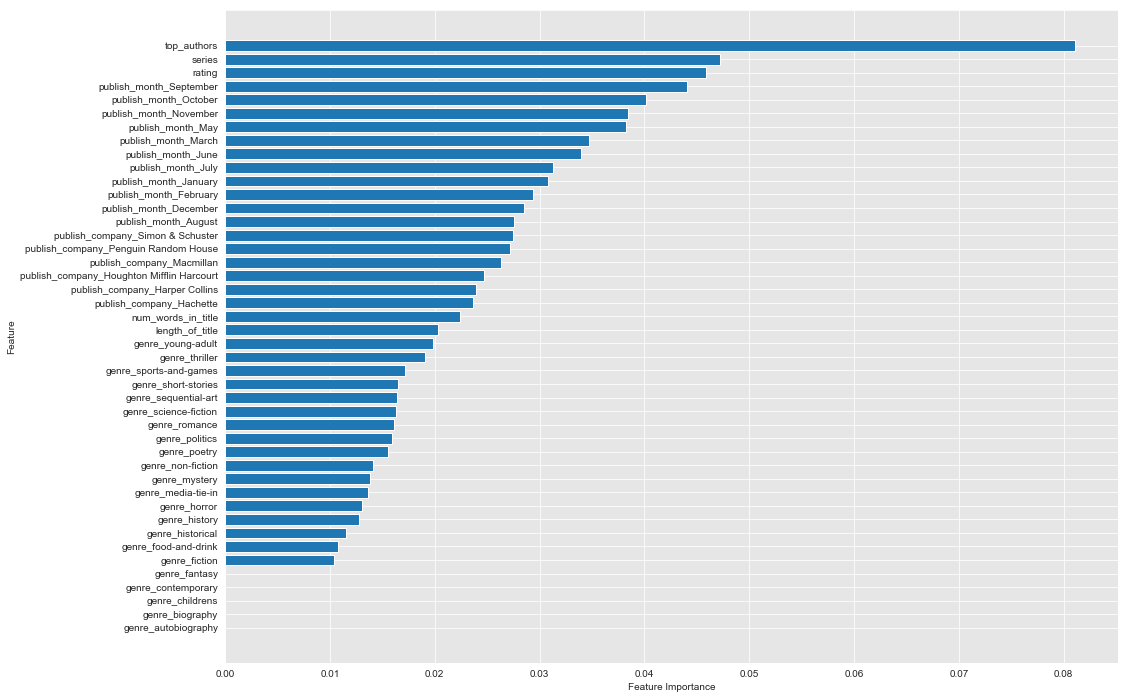

In [212]:
plot_feature_importance(clf,X_train,n=44)